In [ ]:
from google.colab import files

# Upload your ZIP file (archive.zip)
uploaded = files.upload()


Saving archive.zip to archive.zip


In [ ]:
import zipfile, os

zip_path = "archive.zip"  # name of the uploaded file
extract_path = "pet_disease_dataset"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:", extract_path)


✅ Dataset extracted to: pet_disease_dataset


In [ ]:
# pet_cnn_train.py
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

# ================================
# 1️⃣ Dataset Path
# ================================
data_dir = "pet_disease_dataset"  # folder that contains train/, valid/, test/

# ================================
# 2️⃣ Data Preprocessing
# ================================
train_tf = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

val_tf = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_ds = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_tf)
val_ds   = datasets.ImageFolder(os.path.join(data_dir, "valid"), transform=val_tf)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=32)

# ================================
# 3️⃣ Define Simple CNN Model
# ================================
class PetCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# ================================
# 4️⃣ Setup Training
# ================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_ds.classes)
model = PetCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ================================
# 5️⃣ Train (Quick test: 3 epochs)
# ================================
epochs = 3
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for imgs, labels in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()
    val_acc = 100 * val_correct / val_total

    print(f"Epoch {epoch+1}: "
          f"Loss={running_loss/len(train_dl):.4f}, "
          f"TrainAcc={train_acc:.2f}%, ValAcc={val_acc:.2f}%")

# ================================
# 6️⃣ Save Model
# ================================
save_path = "pet_disease_simplecnn.pth"
torch.save(model.state_dict(), save_path)
print(f"\n✅ Model saved as {save_path}")


Epoch 1/3: 100%|██████████| 95/95 [02:20<00:00,  1.48s/it]


Epoch 1: Loss=1.6680, TrainAcc=28.56%, ValAcc=31.98%


Epoch 2/3: 100%|██████████| 95/95 [02:17<00:00,  1.45s/it]


Epoch 2: Loss=1.4948, TrainAcc=38.29%, ValAcc=45.70%


Epoch 3/3: 100%|██████████| 95/95 [02:18<00:00,  1.45s/it]


Epoch 3: Loss=1.3359, TrainAcc=44.77%, ValAcc=50.23%

✅ Model saved as pet_disease_simplecnn.pth


🖼️ Testing image: pet_disease_dataset/test/ringworm/ringworm-150-_jpg.rf.4103d0e5a72e7461a5ba338ecb6399cd.jpg


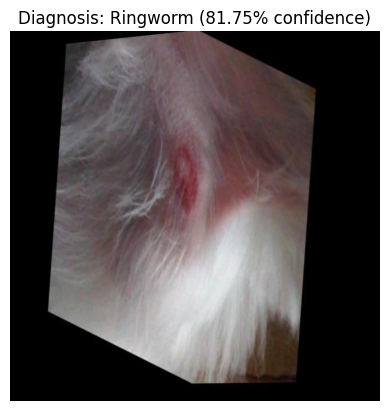

✅ Diagnosis: Ringworm
💊 First Aid Suggestion: Disinfect bedding; apply antifungal ointment; reduce contact.


In [ ]:
# pet_diagnosis_test.py
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
import os

# ================================
# 1️⃣ Define the CNN architecture
# ================================
class PetCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# ================================
# 2️⃣ Load the trained model
# ================================
model_path = "pet_disease_simplecnn.pth"
num_classes = 6
model = PetCNN(num_classes)
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()

# ================================
# 3️⃣ Define classes and first aid
# ================================
class_names = ['Dermatitis', 'Fungal_infections', 'Healthy',
               'Hypersensitivity', 'Demodicosis', 'Ringworm']

first_aid = {
    "Dermatitis": "Clean the area with antiseptic and prevent scratching.",
    "Fungal_infections": "Apply antifungal cream; keep the area dry.",
    "Healthy": "No visible disease. Maintain routine hygiene!",
    "Hypersensitivity": "Avoid allergens; consult a vet if swelling persists.",
    "Demodicosis": "Use medicated shampoo; seek veterinary ivermectin treatment.",
    "Ringworm": "Disinfect bedding; apply antifungal ointment; reduce contact."
}

# ================================
# 4️⃣ Define image transforms
# ================================
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# ================================
# 5️⃣ Pick a random image from test set
# ================================
test_dir = "pet_disease_dataset/test"
random_class = random.choice(os.listdir(test_dir))
random_img_path = os.path.join(test_dir, random_class, random.choice(os.listdir(os.path.join(test_dir, random_class))))

print(f"🖼️ Testing image: {random_img_path}")

# ================================
# 6️⃣ Run inference
# ================================
image = Image.open(random_img_path).convert("RGB")
img_tensor = transform(image).unsqueeze(0)

with torch.no_grad():
    outputs = model(img_tensor)
    probs = torch.softmax(outputs, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()
    confidence = probs[0][pred_idx].item() * 100
    diagnosis = class_names[pred_idx]

# ================================
# 7️⃣ Show results
# ================================
plt.imshow(image)
plt.axis("off")
plt.title(f"Diagnosis: {diagnosis} ({confidence:.2f}% confidence)")
plt.show()

print(f"✅ Diagnosis: {diagnosis}")
print(f"💊 First Aid Suggestion: {first_aid[diagnosis]}")
